In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from matplotlib import rcParams

rcParams["figure.dpi"] = 300

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from labellines import labelLines

from tabulate import tabulate

from the_bootstrap_approach.dataplate import DataPlate
from the_bootstrap_approach.conditions import (
    FullThrottleConditions,
    PartialThrottleConditions
)
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.performance import (
    bootstrap_cruise_performance_table,
    best_rate_of_climb,
    best_range_and_optimum_cruise,
)
from the_bootstrap_approach.propeller_chart import propeller_efficiency

# As glide tested on December 5th 2021, as Z and BAF determined on December 6th
# 2021, using Piper's provided ASI calibration curves.
N51SW = DataPlate(
    # Airplane configuration. e.g., flaps/gear position.
    "Flaps Up",
    # S, reference wing area (ft^2).
    170,
    # B, wing span (ft).
    425.11 / 12,
    # C_{D0}, parasite drag coefficient (depends on flaps/gear configuration).
    0.0357162948271769,
    # e, airplane efficiency factor (possibly depends on flaps configuration).
    0.673966174425770,
    # P_0, rated MSL shaft power at rated RPM.
    235,
    # N_0, rated MSL full-throttle RPM.
    2400,
    # C, engine power altitude dropoff parameter, the porportion of indicated
    # power that goes to engine friction losses (close to 0.12).
    0.12,
    # c, brake specific full consumption rate (lbm/HP/HR).
    # > Model O-540-J3A5D Engines – Manual leaning is permitted at cruise
    # > conditions up to 85% power resulting in a BSFC of .420 lbs./BHP./hr. at
    # > best economy and .460 lbs./BHP./hr. at best power. Minimum allowable
    # > BSFC at take-off and climb conditions is .500 lbs./BHP./hr.
    (0.460, 0.420, 0.500),
    # d, propeller diameter (ft).
    80 / 12,
    # BAF, blade activity factor.
    101.600808244411,
    # Z, ratio of fuselage diameter (taken one propeller diameter behind the
    # propeller) to propeller diameter.
    ((43 + (5 / 16) + 48) / 2) / 80,
)


## Power available, required, and excess.

/Users/rocky/projects/tba/the_bootstrap_approach/equations.py:221: RuntimeWarning: divide by zero encountered in true_divide
  return g * air_speed ** 3 + h / air_speed


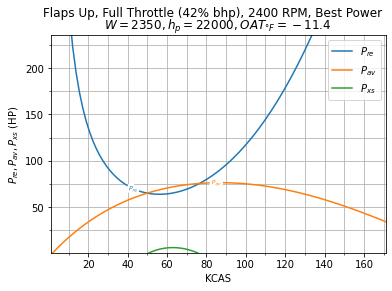

In [3]:
operating_conditions = FullThrottleConditions(
    N51SW, 2350, 22000, c_to_f(-24.1), Mixture.BEST_POWER, 2400
)

fig, ax = plt.subplots()

# $V_{NE}$ for N51SW is 171 KCAS
never_exceed_speed = 171
kcas = np.linspace(0, never_exceed_speed, 100)

p_re = (
    power_required(operating_conditions.g, operating_conditions.h, kn_to_fts(
        tas(
            kcas, 
            operating_conditions.relative_atmospheric_density
        )
    ))
    / 550
)
ax.plot(kcas, p_re, label=r"$P_{re}$")

p_av = (
    power_available(
        propeller_efficiency(
            sdef_t(N51SW.z_ratio),
            propeller_advance_ratio(
                kn_to_fts(
                    tas(
                        kcas, 
                        operating_conditions.relative_atmospheric_density
                    )
                ),
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            propeller_power_coefficient(
                operating_conditions.power,
                operating_conditions.atmospheric_density,
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            power_adjustment_factor_x(N51SW.total_activity_factor),
        ),
        operating_conditions.power,
    )
    / 550
)
ax.plot(kcas, p_av, label=r"$P_{av}$")

p_xs = p_av - p_re
ax.plot(kcas, p_xs, label=r"$P_{xs}$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

plt.suptitle(
    f"{N51SW.configuration}, {operating_conditions.desc} ({operating_conditions.power / N51SW.rated_full_throttle_engine_power * 100:.0f}% bhp), {operating_conditions.engine_rpm} RPM, {operating_conditions.mixture.value}"
)

ax.set(
    xlabel="KCAS",
    ylabel=r"$P_{re}, P_{av}, P_{xs}$ (HP)",
    title=f"$W = {operating_conditions.gross_aircraft_weight}, h_p = {operating_conditions.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {operating_conditions.oat_f:.1f}$",
)

ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))
ax.yaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([1, never_exceed_speed])
ax.set_ylim([1, N51SW.rated_full_throttle_engine_horsepower])

plt.legend()

plt.show()


In [4]:
operating_conditions = FullThrottleConditions(
    N51SW, 2700, 15000, c_to_f(-24), Mixture.BEST_POWER, 2400
)

table = bootstrap_cruise_performance_table(N51SW, operating_conditions, 60, 180, 0.5)

print(
    f"{N51SW.configuration}, {operating_conditions.desc} ({operating_conditions.power / N51SW.rated_full_throttle_engine_power * 100:.0f}% bhp), {operating_conditions.engine_rpm} RPM, {operating_conditions.mixture.value}"
)
print(
    f"$W = {operating_conditions.gross_aircraft_weight}, h_p = {operating_conditions.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {operating_conditions.oat_f:.1f}$",
)
print(
    tabulate(
        table,
        headers=[
            "KCAS",
            "KTAS",
            "η",
            "h",
            "γ",
            "RPM",
            "% bhp",
            "gph",
            "T/V",
            "mpg",
        ],
        tablefmt="simple",
        floatfmt=(".1f", ".1f", ".4f", ".0f", ".0f", ".0f", ".2f", ".2f", ".2f"),
    )
)


Flaps Up, Full Throttle (60% bhp), 2400 RPM, Best Power
$W = 2700, h_p = 15000, {OAT_{\degree{F}}} = -11.2$
  KCAS    KTAS       η      h      γ    RPM    % bhp    gph    T/V       mpg
------  ------  ------  -----  -----  -----  -------  -----  -----  --------
  60.0    74.3  0.6581    310    250   2400    60.48  10.90   3.27   6.81798
  60.5    74.9  0.6609    315    252   2400    60.48  10.90   3.23   6.87479
  61.0    75.5  0.6636    319    254   2400    60.48  10.90   3.19   6.93161
  61.5    76.2  0.6663    324    255   2400    60.48  10.90   3.15   6.98843
  62.0    76.8  0.6690    328    256   2400    60.48  10.90   3.12   7.04524
  62.5    77.4  0.6717    332    257   2400    60.48  10.90   3.08   7.10206
  63.0    78.0  0.6743    335    258   2400    60.48  10.90   3.04   7.15888
  63.5    78.6  0.6768    339    258   2400    60.48  10.90   3.00   7.21569
  64.0    79.2  0.6794    342    259   2400    60.48  10.90   2.97   7.27251
  64.5    79.9  0.6819    345    259   2400  

In [5]:
def performance_profiles(gross_aircraft_weight):
    best_rate_of_climb_profile = []
    best_range_profile = []
    optimum_cruise_profile = []

    # Piper publishes a service ceiling of 17,500 ft. Originally, I only wanted to
    # determine performance up to 18,000 ft, as our Cannula's are only approved that
    # high. However, I reached 18,000 ft, the plane wanted to keep climbing, and I
    # had a mask. I was able to reach 22,500 ft in the Dakota, and the performance I
    # saw is identical to these charts.
    for pressure_altitude in np.arange(0, 26000, 1000):
        # Determine ISA temperature for pressure altitude.
        oat_f = 59.0 - (pressure_altitude / 1000 * 3.5)

        best_rate = best_rate_of_climb(
            N51SW,
            FullThrottleConditions(
                N51SW,
                gross_aircraft_weight,
                pressure_altitude,
                oat_f,
                Mixture.BEST_POWER,
                2400,
            ),
        )

        # If the rate of climb is negative, the aircraft isn't able to sustain level flight.
        if best_rate[4] > 0:
            best_rate_of_climb_profile.append(
                np.insert(
                    best_rate,
                    0,
                    pressure_altitude,
                )
            )

        best_range, optimum_cruise = best_range_and_optimum_cruise(
            N51SW, gross_aircraft_weight, pressure_altitude, oat_f, Mixture.BEST_ECONOMY
        )

        if best_range[4] > 0:
            best_range_profile.append(np.insert(best_range, 0, pressure_altitude))
        if optimum_cruise[4] > 0:
            optimum_cruise_profile.append(
                np.insert(optimum_cruise, 0, pressure_altitude)
            )

    return best_rate_of_climb_profile, best_range_profile, optimum_cruise_profile


best_rate_of_climb_profiles = {}
best_range_profiles = {}
optimum_cruise_profiles = {}

for gross_aircraft_weight in (2000, 2500, 2750, 3000):
    (
        best_rate_of_climb_profile,
        best_range_profile,
        optimum_cruise_profile,
    ) = performance_profiles(gross_aircraft_weight)

    best_rate_of_climb_profiles[gross_aircraft_weight] = best_rate_of_climb_profile
    best_range_profiles[gross_aircraft_weight] = best_range_profile
    optimum_cruise_profiles[gross_aircraft_weight] = optimum_cruise_profile


headers = ("h_ρ", "KCAS", "KTAS", "η", "h", "γ", "RPM", "% bhp", "gph", "mpg")
tablefmt = "latex_booktabs"
floatfmt = (".0f", ".1f", ".1f", ".4f", ".0f", ".0f", ".0f", ".2f", ".2f", ".2f")

for gross_aircraft_weight, profile in best_rate_of_climb_profiles.items():
    print(
        f"Best Rate of Climb (V_y), {N51SW.configuration}, Full Throttle, 2400 RPM, {Mixture.BEST_POWER.value}",
        "\n",
        f"W = {gross_aircraft_weight}, ISA+0, V_w = 0",
        "\n",
        tabulate(
            np.delete(profile, [9], axis=1),
            headers=headers,
            tablefmt=tablefmt,
            floatfmt=floatfmt,
        ),
        "\n",
        sep="",
    )

for gross_aircraft_weight, profile in best_range_profiles.items():
    print(
        f"Best Range, {N51SW.configuration}, {Mixture.BEST_ECONOMY.value}",
        "\n",
        f"W = {gross_aircraft_weight}, ISA+0, V_w = 0",
        "\n",
        tabulate(
            np.delete(profile, [9], axis=1),
            headers=headers,
            tablefmt=tablefmt,
            floatfmt=floatfmt,
        ),
        "\n",
        sep="",
    )

for gross_aircraft_weight, profile in optimum_cruise_profiles.items():
    print(
        f"Optimum Cruise (Carson's Speed), {N51SW.configuration}, {Mixture.BEST_ECONOMY.value}",
        "\n",
        f"W = {gross_aircraft_weight}, ISA+0, V_w = 0",
        "\n",
        tabulate(
            np.delete(profile, [9], axis=1),
            headers=headers,
            tablefmt=tablefmt,
            floatfmt=floatfmt,
        ),
        "\n",
        sep="",
    )


Best Rate of Climb (V_y), Flaps Up, Full Throttle, 2400 RPM, Best Power
W = 2000, ISA+0, V_w = 0
\begin{tabular}{rrrrrrrrrr}
\toprule
   h\_ρ &   KCAS &   KTAS &      η &    h &    γ &   RPM &   \% bhp &   gph &   mpg \\
\midrule
     0 &   79.8 &   79.8 & 0.6653 & 1769 & 1330 &  2400 &  100.00 & 18.02 &  4.43 \\
  1000 &   78.8 &   80.0 & 0.6669 & 1694 & 1271 &  2400 &   96.70 & 17.42 &  4.59 \\
  2000 &   77.7 &   80.0 & 0.6681 & 1620 & 1215 &  2400 &   93.47 & 16.84 &  4.75 \\
  3000 &   76.7 &   80.2 & 0.6698 & 1548 & 1158 &  2400 &   90.31 & 16.27 &  4.93 \\
  4000 &   75.7 &   80.3 & 0.6715 & 1476 & 1102 &  2400 &   87.23 & 15.72 &  5.11 \\
  5000 &   74.7 &   80.5 & 0.6731 & 1406 & 1048 &  2400 &   84.22 & 15.17 &  5.31 \\
  6000 &   73.7 &   80.6 & 0.6748 & 1336 &  994 &  2400 &   81.27 & 14.64 &  5.51 \\
  7000 &   72.7 &   80.8 & 0.6765 & 1268 &  942 &  2400 &   78.40 & 14.12 &  5.72 \\
  8000 &   71.8 &   81.0 & 0.6787 & 1201 &  889 &  2400 &   75.59 & 13.62 &  5.95 \\
  900

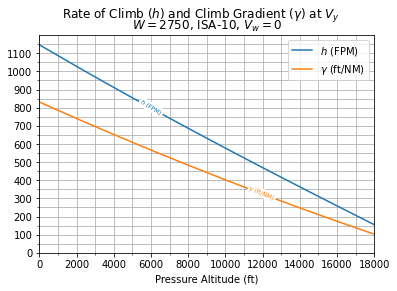

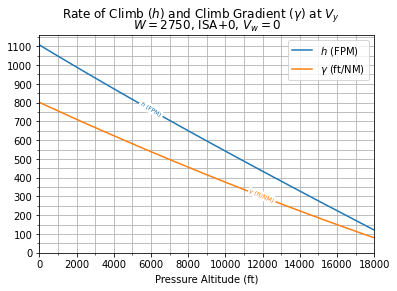

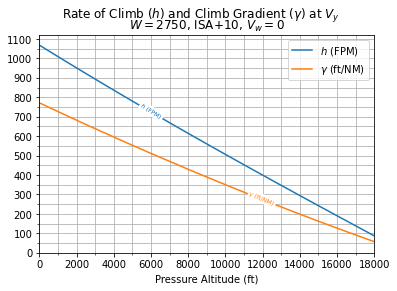

In [6]:
def enroute_climb_gradient_graph(gross_aircraft_weight, isa_diff=0):
    pressure_altitude = np.linspace(0, 18000, 100)

    roc = []
    aoc = []

    for i in pressure_altitude:
        vy = best_rate_of_climb(
            N51SW,
            FullThrottleConditions(
                N51SW,
                gross_aircraft_weight,
                i,
                59.0 - (i / 1000 * 3.5) + isa_diff,
                Mixture.BEST_POWER,
                2400,
            ),
        )
        roc.append(vy[3])
        aoc.append(vy[4])

    fig, ax = plt.subplots()

    ax.plot(pressure_altitude, roc, label=r"$h$ (FPM)")
    ax.plot(pressure_altitude, aoc, label=r"$\gamma$ (ft/NM)")

    labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

    plt.suptitle(f"Rate of Climb ($h$) and Climb Gradient ($\gamma$) at $V_y$")

    ax.set(
        xlabel="Pressure Altitude (ft)",
        title=f"$W = {gross_aircraft_weight}$, ISA{isa_diff:+}, $V_w = 0$",
    )

    ax.grid(True, which="both")

    ax.xaxis.set_major_locator(MultipleLocator(2000))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xlim([0, 18000])
    ax.set_ylim(bottom=0)

    plt.legend()

    plt.savefig(f"best_rate_of_climb_{gross_aircraft_weight}_isa{isa_diff:+}.jpg", format="jpg")
    plt.show()


enroute_climb_gradient_graph(2750, -10)
enroute_climb_gradient_graph(2750, 0)
enroute_climb_gradient_graph(2750, 10)


## How full-throttle V-speeds vary with density altitude.

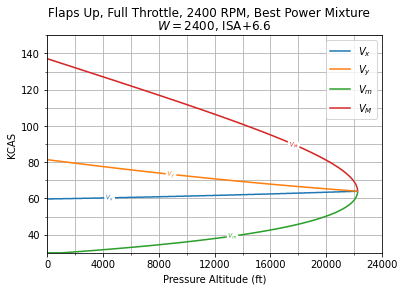

In [7]:
gross_aircraft_weight = 2400

vx = []
vy = []
min_level_flight_speed = []
max_level_flight_speed = []

# Find me a way to clip at the intersection of the curves and this won't need to
# be some arbitrary constant 😭.
pressure_altitude = np.arange(0, 22260, 10)

for i in pressure_altitude:
    operating_conditions = FullThrottleConditions(
        N51SW,
        2500,
        i,
        59.0 - (i / 1000 * 3.5) + 6.6,
        Mixture.BEST_POWER,
        2400,
    )

    table = bootstrap_cruise_performance_table(
        N51SW, operating_conditions, 30, 180, 0.1
    )

    # Vx, best angle of climb.
    aoc = table[:, 4]
    index_of_highest_aoc = aoc.argmax()
    vx.append(table[index_of_highest_aoc][0])

    # Vy, best rate of climb.
    roc = table[:, 3]
    index_of_highest_roc = roc.argmax()
    vy.append(table[index_of_highest_roc][0])

    # V_m, minimum level flight speed (in practice, Vm seldom occurs, because
    # the power-on stall speed is usually much higher).
    roc_before_peak = roc[:index_of_highest_roc]
    if roc_before_peak.size > 0:
        index_min_level_flight_speed = np.where(
            roc_before_peak > 0, roc_before_peak, np.inf
        ).argmin()
    else:
        index_min_level_flight_speed = 0
    min_level_flight_speed.append(table[index_min_level_flight_speed][0])

    # V_M, maximum level flight speed.
    roc_after_peak = roc[index_of_highest_roc:]
    index_max_level_flight_speed = np.where(
        roc_after_peak > 0, roc_after_peak, np.inf
    ).argmin()
    max_level_flight_speed.append(
        table[index_of_highest_roc + index_max_level_flight_speed][0]
    )

fig, ax = plt.subplots()

ax.plot(pressure_altitude, vx, label=r"$V_x$")
ax.plot(pressure_altitude, vy, label=r"$V_y$")
ax.plot(pressure_altitude, min_level_flight_speed, label=r"$V_m$")
ax.plot(pressure_altitude, max_level_flight_speed, label=r"$V_M$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

plt.suptitle(
    f"{N51SW.configuration}, Full Throttle, 2400 RPM, {Mixture.BEST_POWER.value} Mixture"
)

ax.set(
    xlabel="Pressure Altitude (ft)",
    ylabel="KCAS",
    title=f"$W = {gross_aircraft_weight}$, ISA+6.6",
)

ax.grid(True, which="both")

ax.xaxis.set_major_locator(MultipleLocator(4000))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.set_xlim([0, 24000])
ax.set_ylim([30, 150])

plt.legend()

plt.savefig('flight_envelope.jpg', format='jpg')
plt.show()


|   pressure_altitude |   kcas |   ktas |    eta |   thrust |   drag |   roc |   aoc |   ftnm |   pre |      pav |    pxs |     rpm |   pbhp |   gph |   fuel_flow_per_knot |   mpg |
|---------------------|--------|--------|--------|----------|--------|-------|-------|--------|-------|----------|--------|---------|--------|-------|----------------------|-------|
|                   0 |  115.7 |  115.7 | 0.7608 |    327.3 |  327.1 |     1 |     0 |      1 | 63873 | 63918.86 |  46.06 | 2400.00 |  64.95 | 11.70 |                 1.68 |  9.89 |
|                1000 |  115.1 |  116.8 | 0.7624 |    324.9 |  324.8 |     0 |     0 |      0 | 64031 | 64049.32 |  18.27 | 2400.00 |  64.98 | 11.71 |                 1.65 |  9.98 |
|                2000 |  114.4 |  117.8 | 0.7640 |    322.7 |  322.1 |     3 |     0 |      2 | 64065 | 64189.72 | 124.97 | 2400.00 |  64.87 | 11.69 |                 1.62 | 10.08 |
|                3000 |  113.8 |  119.0 | 0.7657 |    320.3 |  319.9 |     2 |     0 |    

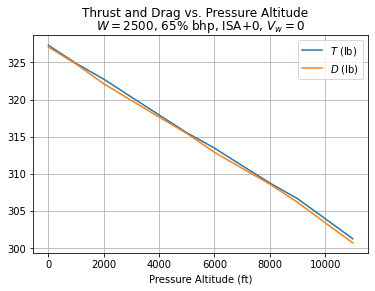

In [13]:
def thrust_drag_vs_altitude(gross_aircraft_weight, isa_diff=0):
    thrust = []
    drag = []

    gama_cruise = []

    x = np.arange(0, 12000, 1000)

    for pressure_altitude in x:
        # Determine ISA temperature for pressure altitude.
        oat_f = 59.0 - (pressure_altitude / 1000 * 3.5)

        table = bootstrap_cruise_performance_table(N51SW,
            PartialThrottleConditions(
                N51SW,
                gross_aircraft_weight,
                pressure_altitude,
                oat_f,
                Mixture.BEST_POWER,
                2400, 
                N51SW.rated_full_throttle_engine_power * 0.65
            ), 60, 180, 0.1, expanded=True
        )

        # V_y, best rate of climb.
        roc = table[:, 5]
        index_of_highest_roc = roc.argmax()

        # V_M, maximum level flight speed.
        roc_after_peak = roc[index_of_highest_roc:]
        index_max_level_flight_speed = np.where(
            roc_after_peak > 0, roc_after_peak, np.inf
        ).argmin() + index_of_highest_roc

        gama_cruise.append(
            np.insert(table[index_max_level_flight_speed], 0, pressure_altitude)
        )

        thrust.append(table[index_max_level_flight_speed][3])
        drag.append(table[index_max_level_flight_speed][4])


    headers = ("pressure_altitude", "kcas", "ktas", "eta", "thrust", "drag", "roc", "aoc", "ftnm", "pre", "pav", "pxs", "rpm", "pbhp", "gph", "fuel_flow_per_knot", "mpg")
    tablefmt = "github"
    floatfmt = (".0f", ".1f", ".1f", ".4f", ".1f", ".1f", ".0f", ".0f", ".0f", ".0f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f")
    print(
        tabulate(
            gama_cruise,
            headers=headers,
            tablefmt=tablefmt,
            floatfmt=floatfmt,
        )
    )

    fig, ax = plt.subplots()

    ax.plot(x, thrust, label=r"$T$ (lb)")
    ax.plot(x, drag, label=r"$D$ (lb)")

    # labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

    plt.suptitle(f"Thrust and Drag vs. Pressure Altitude")

    ax.set(
        xlabel="Pressure Altitude (ft)",
        title=f"$W = {gross_aircraft_weight}$, {0.65 * 100:.0f}% bhp, ISA{isa_diff:+}, $V_w = 0$",
    )

    ax.grid(True, which="both")

    # ax.xaxis.set_major_locator(MultipleLocator(2000))
    # ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    # ax.yaxis.set_major_locator(MultipleLocator(100))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # ax.set_xlim([0, 18000])
    # ax.set_ylim(bottom=0)

    plt.legend()

    plt.show()

thrust_drag_vs_altitude(2500, isa_diff=0)